In [33]:
### Library Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [34]:
### Function to Import Rate Data
def import_fx_data(tickers, start_date):
    data = pd.DataFrame()
    if isinstance(tickers, str):
        tickers = [tickers]
        
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start = start_date)['Adj Close']
        
    # Reset index to make headings in the same row
    data.reset_index(inplace = True)
    # Convert values in date col to dt
    data['Date'] = pd.to_datetime(data['Date'])

    return data

### Call Function to Load in Rate Data
forex_pairs = ['GBPJPY=X', 'GBPCHF=X']
start_date = '2021-01-01'
forex_data = import_fx_data(forex_pairs, start_date)
forex_data.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,GBPJPY=X,GBPCHF=X
896,2024-06-10,199.610001,1.14040
897,2024-06-11,199.843994,1.14096
898,2024-06-12,200.143005,1.14372
899,2024-06-13,200.630997,1.14400
900,2024-06-14,200.419998,1.14024


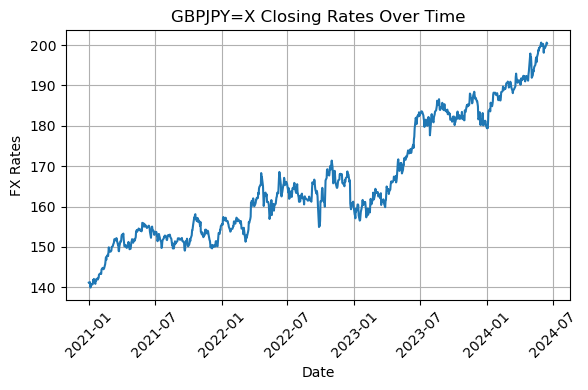

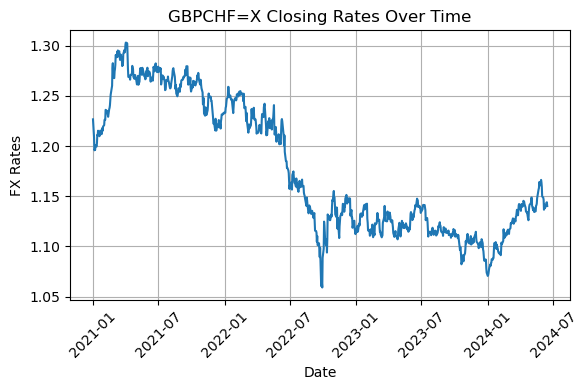

In [35]:
### Plot FX Rate Data
def plot_forex(df, forex_pairs):
    # Create Loop to Plot Each Individual FX Pair
    for pair in forex_pairs:
        plt.figure(figsize = (6, 4))

        plt.plot(df['Date'], df[pair]) # Need to adjust to spit out multiple graphs for each ticker
        plt.title(pair + ' Closing Rates Over Time')
        plt.xlabel('Date')
        plt.ylabel('FX Rates')

        plt.xticks(rotation = 45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()

    return plt.show()

### Plot FX Pairs
plot_forex(forex_data, forex_pairs)

In [36]:
### Compute Direct Hedge Daily Returns
def direct_daily_rets(fx_data):
    # Ensure 'Date' is set as the index for proper computation
    fx_data.set_index('Date', inplace=True)
    
    # Compute the daily returns of the forex data
    rets = fx_data.pct_change().dropna()
    
    # Reset index to make date a column again
    rets.reset_index(inplace=True)

    return rets

### Call Function to Calculate Daily Returns
daily_returns = direct_daily_rets(forex_data)
print(daily_returns.head())


        Date  GBPJPY=X  GBPCHF=X
0 2021-01-04  0.000829 -0.014968
1 2021-01-05 -0.009373 -0.010321
2 2021-01-06 -0.000029  0.000811
3 2021-01-07  0.002937 -0.000460
4 2021-01-08  0.003406  0.003963


In [37]:
### Compute Hedge Ratio
def compute_hedge_ratio(pairs, returns):
    # Run linear regression to compute the hedge ratio
    rets1 = returns[pairs[0]]
    rets2 = returns[pairs[1]]
    # Add a constant to the independent variable
    rets1 = sm.add_constant(rets1)
    # Fit the regression model
    model = sm.OLS(rets2, rets1).fit()
    # Extract the hedge ratio
    hedge_ratio = model.params[pairs[0]]

    return hedge_ratio

### Call Hedge Ratio Function
hedge_ratio = compute_hedge_ratio(forex_pairs, daily_returns)
print("Hedge Ratio:", hedge_ratio)

Hedge Ratio: 0.41093360152030345


In [38]:
### Define and Calculate Hedged and Unhedged Returns
def calculate_hedged_unhedged(long_pos, pairs, returns, hedge_ratio):
    # Compute Short Position
    short_pos = -hedge_ratio * long_pos

    # Compute daily returns for the long and short positions
    long_rets = returns[pairs[0]]
    short_rets = -hedge_ratio * returns[pairs[1]]

    # Compute the returns of the hedged and unhedged positions
    hedged_rets = long_rets + short_rets
    unhedged_rets = long_rets

    # Compute cumulative returns for the hedged and unhedged positions
    hedged_cumulative_rets = (1 + hedged_rets).cumprod() * long_pos
    unhedged_cumulative_rets = (1 + unhedged_rets).cumprod() * long_pos

    return short_pos, hedged_cumulative_rets, unhedged_cumulative_rets
    

### Function Call to return Hedged and Unhedged Cumulative Returns
# Set value of Long Position
long_pos = 1000  
short_pos, hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(long_pos, forex_pairs, daily_returns, hedge_ratio)
print("Long Position Size: ", long_pos)
print("Short Position Size: ", round(short_pos, 4))
print("Recent Hedged Cumulative Returns: ", hedged_cumulative_rets.tail(5))
print("Recent Unhedged Cumulative Returns: ", unhedged_cumulative_rets.tail(5))

Long Position Size:  1000
Short Position Size:  -410.9336
Recent Hedged Cumulative Returns:  895    1457.151435
896    1458.565584
897    1459.298002
898    1462.709261
899    1463.146584
dtype: float64
Recent Unhedged Cumulative Returns:  895    1414.269530
896    1415.927413
897    1418.045956
898    1421.503455
899    1420.008495
Name: GBPJPY=X, dtype: float64


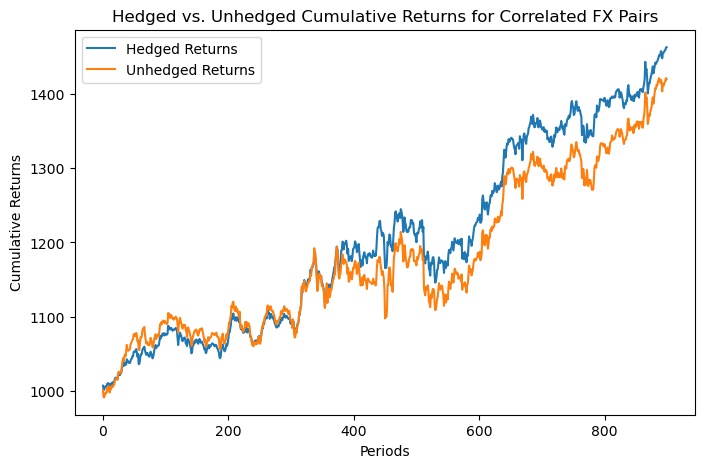

In [39]:
### Plot Hedged vs. Unhedged Returns
def plot_hedged_returns(hedged_cumulative_rets, unhedged_cumulative_rets):
    plt.figure(figsize = (8, 5))
    plt.plot(hedged_cumulative_rets.index, hedged_cumulative_rets, label = 'Hedged Returns')
    plt.plot(unhedged_cumulative_rets.index, unhedged_cumulative_rets, label = 'Unhedged Returns')
    plt.xlabel('Periods')
    plt.ylabel('Cumulative Returns')
    plt.title('Hedged vs. Unhedged Cumulative Returns for Correlated FX Pairs')
    plt.legend()

    return plt.show()

### Plot Hedged vs. Unhedged Returns
plot_hedged_returns(hedged_cumulative_rets, unhedged_cumulative_rets)

In [40]:
### Function to Compute Performance Metrics
def performance_metrics(long_pos, hedged_cumulative_rets, unhedged_cumulative_rets, returns):
    # Drop na values for proper analysis
    hedged_cumulative_rets.dropna()
    unhedged_cumulative_rets.dropna()

    # Compute Hedged/Unhedged Total Returns (Current - Start)
    hedged_total_rets = hedged_cumulative_rets.iloc[-1] - long_pos
    unhedged_total_rets = unhedged_cumulative_rets.iloc[-1] - long_pos

    # Compute Hedged/Unhedged Annualized Returns
    hedged_ann_rets = (1 + hedged_total_rets)**(252 / len(returns)) - 1
    unhedged_ann_rets = (1 + unhedged_total_rets)**(252 / len(returns)) - 1

    # Compute Hedged/Unhedged Mean Returns
    hedged_mean = np.mean(hedged_cumulative_rets)
    unhedged_mean = np.mean(unhedged_cumulative_rets)

    # Compute Hedged/Unhedged Mean Returns
    hedged_stddev = np.std(hedged_cumulative_rets)
    unhedged_stddev = np.std(unhedged_cumulative_rets)

    # Compute the Hedged/Unhedged Sharpe Ratio
    hedged_sharpe_ratio = hedged_mean / hedged_stddev * np.sqrt(252)
    unhedged_sharpe_ratio = unhedged_mean / unhedged_stddev * np.sqrt(252) 

    # Enhanced readability using formatted strings
    print(f"{'Metric':<30} {'Hedged':>15} {'Unhedged':>15}")
    print("="*60)
    print(f"{'Total Returns':<30} {hedged_total_rets:>15.4f} {unhedged_total_rets:>15.4f}")
    print(f"{'Annualized Returns':<30} {hedged_ann_rets:>15.4f} {unhedged_ann_rets:>15.4f}")
    print(f"{'Mean Return':<30} {hedged_mean:>15.4f} {unhedged_mean:>15.4f}")
    print(f"{'Standard Deviation':<30} {hedged_stddev:>15.4f} {unhedged_stddev:>15.4f}")
    print(f"{'Sharpe Ratio':<30} {hedged_sharpe_ratio:>15.4f} {unhedged_sharpe_ratio:>15.4f}")

    # Explanation of Sharpe Ratio in print statements
    print(f"\nThe Sharpe ratio measures the risk-adjusted return of an investment.")
    print(f"In this instance, the hedged strategy has a Sharpe ratio of {hedged_sharpe_ratio:.4f},")
    print(f"which means for every unit of risk, the hedged portfolio is generating {hedged_sharpe_ratio:.4f} units of return above the risk-free rate.")
    print(f"The unhedged strategy has a Sharpe ratio of {unhedged_sharpe_ratio:.4f},")
    print(f"indicating that for every unit of risk, the unhedged portfolio is generating {unhedged_sharpe_ratio:.4f} units of return above the risk-free rate.")
    print(f"A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.")

### Performance Metrics Function Return
performance_metrics(long_pos, hedged_cumulative_rets, unhedged_cumulative_rets, daily_returns)

Metric                                  Hedged        Unhedged
Total Returns                         463.1466        420.0085
Annualized Returns                      4.5804          4.4300
Mean Return                          1202.3658       1179.1989
Standard Deviation                    127.9152        104.8942
Sharpe Ratio                          149.2158        178.4580

The Sharpe ratio measures the risk-adjusted return of an investment.
In this instance, the hedged strategy has a Sharpe ratio of 149.2158,
which means for every unit of risk, the hedged portfolio is generating 149.2158 units of return above the risk-free rate.
The unhedged strategy has a Sharpe ratio of 178.4580,
indicating that for every unit of risk, the unhedged portfolio is generating 178.4580 units of return above the risk-free rate.
A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.
